In [1]:
import glob 
import numpy as np 
import os 
import shutil 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt 

In [2]:
filesTrainCOV= glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/*')
filesTrainNO=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/*')
filesTestCOV=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*')
filesTestNO=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*')
filesValCOV=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*')
filesValNO=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images/*')

In [3]:
COVID_train = [fn for fn in filesTrainCOV if 'covid' in fn] 
HEALTHY_train = [fn for fn in filesTrainNO if 'COVID' in fn] 
 
COVID_val = [fn for fn in filesValCOV if 'covid' in fn] 
HEALTHY_val = [fn for fn in filesValNO if 'COVID' in fn] 

COVID_test = [fn for fn in filesTestCOV if 'covid' in fn] 
HEALTHY_test = [fn for fn in filesTestNO if 'COVID' in fn]  
len(COVID_train), len(COVID_val), len(COVID_test) ,len(HEALTHY_train), len(HEALTHY_val), len(HEALTHY_test)


(7658, 1903, 2395, 7208, 1802, 2253)

In [4]:
train_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/train' 
val_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/valid' 
test_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/test' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
test_files = np.concatenate([COVID_test, HEALTHY_test])
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
for fn in test_files: 
    shutil.copy(fn, test_dir) 
 

In [5]:
test_files.shape

(4648,)

In [6]:
IMG_DIM = (150, 150) 
 
train_files = glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 

validation_files = glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/valid/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (14866, 150, 150, 3) Validation dataset shape: (3705, 150, 150, 3)


In [7]:
train_labels=train_labels[:10000]
validation_labels=validation_labels[:2000]

In [8]:
train_imgs=train_imgs[:10000]
validation_imgs=validation_imgs[:2000]

(150, 150, 3)


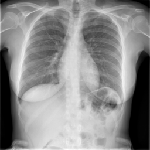

In [9]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

In [10]:
for i in range(10000):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(2000):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [11]:
batch_size = 30 
num_classes = 2 
epochs = 30 
input_shape = (150, 150, 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['covid', 'covid', 'covid', 'covid', 'covid'] [0 0 0 0 0]


In [21]:
train_datagen = ImageDataGenerator(rescale=1./255) 
 
val_datagen = ImageDataGenerator(rescale=1./255) 

In [22]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc,  
                                     batch_size=30) 
val_generator = val_datagen.flow(validation_imgs, 
                                 validation_labels_enc, 
                                 batch_size=20) 

In [13]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 
 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = True 
set_trainable = False
 
for layer in vgg_model.layers: 
    if layer.name in ['block5_conv1', 'block4_conv1']: 
        set_trainable = True 
    if set_trainable: 
        layer.trainable = True 
    else: 
        layer.trainable = False 

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\hecto\AppData\Local\Temp\ipykernel_24108\1885812186.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001424112C700>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F374E9A0>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F359C070>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000141F316EFA0>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F359C700>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F3BA5700>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000141F3BA5C40>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F3BA5730>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F3BB9070>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000141F3BC8940>,block3_conv3,False


In [16]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = Sequential() 

model.add(vgg_model) 
model.add(Dense(512, activation='relu', input_dim=input_shape)) 
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop('learning=rate'=1e-5), 
              metrics=['accuracy']) 

C:\Users\hecto\miniconda3\envs\tfgpu\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
history = model.fit(train_generator, steps_per_epoch=100, 
                              epochs=2,  
                              validation_data=val_generator,   
                              validation_steps=50,  
                              verbose=1)

C:\Users\hecto\AppData\Local\Temp\ipykernel_24108\2419898490.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=100,


Epoch 1/2
100/100 [==============================] - 27s 191ms/step - loss: 0.4011 - accuracy: 0.8230 - val_loss: 0.1196 - val_accuracy: 0.9610
Epoch 2/2
100/100 [==============================] - 17s 170ms/step - loss: 0.1987 - accuracy: 0.9220 - val_loss: 0.1283 - val_accuracy: 0.9540


In [27]:
cm2 = confusion_matrix(validation_labels_enc, history.predict())
print(cm2)
accuracy_score(validation_labels_enc, history.predict())

AttributeError: 'History' object has no attribute 'predict'